<a href="https://colab.research.google.com/github/alexyev/pennylane_projects/blob/master/Quantum_Gradients_w_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

In [5]:
np.random.seed(42)

dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev, diff_method='parameter-shift')
def circuit(params):
  qml.RX(params[0], wires=0)
  qml.RY(params[1], wires=1)
  qml.RZ(params[2], wires=2)

  qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern='ring')

  qml.RX(params[3], wires=0)
  qml.RY(params[4], wires=1)
  qml.RZ(params[5], wires=2)

  qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern='ring')
  return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))


In [6]:
params = np.random.random([6], requires_grad=True)
print('Parameters:', params)
print('Expectation Value: ', circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation Value:  -0.11971365706871569


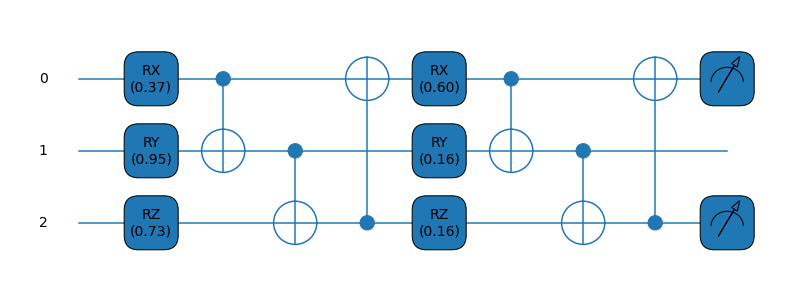

In [7]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [14]:
def parameter_shift_term(qnode, params, i):
  shifted = params.copy()
  shifted[i] += np.pi/2
  forward = qnode(shifted)

  shifted[i] -= np.pi
  backward = qnode(shifted)

  return 0.5 * (forward - backward)

print(parameter_shift_term(circuit, params, 0))

-0.0651887722495813


In [17]:
def parameter_shift(qnode, params):
  gradients = np.zeros([len(params)])

  for i in range(len(params)):
    gradients[i] = parameter_shift_term(qnode, params, i)

  return gradients

print(parameter_shift(circuit, params))


[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  8.32667268e-17]


In [18]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

-0.0651887722495813


In [19]:
print(qml.gradients.param_shift(circuit)(params))

[[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
  -7.61067572e-01  8.32667268e-17]]


In [20]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, diff_method='parameter-shift')
def circuit(params):
  qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
  return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [21]:
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(params.size)
print(circuit(params))

180
0.8947771876917632


In [23]:
import timeit

reps = 3
num = 10
times = timeit.repeat('circuit(params)', globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best out of {reps}): {forward_time} sec per loop")

Forward pass (best out of 3): 0.02410548329989979 sec per loop


In [25]:
grad_fn = qml.grad(circuit)

times = timeit.repeat('grad_fn(params)', globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f'Gradient computation (best of {reps}: {backward_time} sec per loop)')

Gradient computation (best of 3: 6.955476114399971 sec per loop)


In [26]:
print(2 * forward_time * params.size)

8.677973987963924
